In [24]:
import os
import logging
from pathlib import Path
import datetime
import xml.etree.ElementTree as ET

from tqdm import tqdm
import numpy as np
import math
import pandas as pd
import random

import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
# Not needed
# from torchvision.transforms import ToTensor 
# from torchvision.transforms.v2 import (Compose, ToImage, ToDtype, 
#                                        Normalize, RandomPhotometricDistort)

import albumentations as A
from albumentations.pytorch import ToTensorV2

import matplotlib.pyplot as plt

import torch.nn as nn 
from torch.nn.utils import parameters_to_vector
import torch.optim as optim

import torchmetrics

import cv2

In [25]:
#torch.cuda.empty_cache()

# Logger

In [26]:
log_path = 'results_2_100_epochs/'

logger = logging.getLogger("GonLogger")
logger.propagate = False
logger.setLevel(logging.INFO)
file_handler = logging.FileHandler(log_path + 'logfile.log')
formatter = logging.Formatter('%(message)s')
file_handler.setFormatter(formatter)

# add file handler to logger
logger.addHandler(file_handler)

logger.info('BED Classifier XS Tiny. 255 Normalization. Weighted for Precision.')

# Config

In [27]:
CLASSES = ["smoke", "fire"]
N_CLASSES = len(CLASSES)

IMG_DIM = {'W':224, 'H':224} # (W, H)
IMG_H = IMG_DIM['H']
IMG_W = IMG_DIM['W']

# Dataset

# DFire

In [28]:
class DFireDataset(Dataset):
    '''
    Creates a Pytorch Dataset to train the Yolov1 Network.
    Encodes labels to match the format [xcell, ycell, w, h, confidence, class_0 (smoke), class_1 (fire)]
        - Final encoding format is: [xcell, ycell, w, h, conf=1, smoke?, fire?]

    Discard images when there are more than 1 object in the same cell
    
    Arguments:
        - img_h:            image height
        - img_w:            image width
        - img_dir:          path to images folder
        - label_dir:        path to labels folder
        - num_classes:      number of classes
        - transform:        transformation applied to input images -> Albumentations
        - target_transform: transformation applied to labels -> nothing by default

    Return:
        - img:              1 image of the dataset
        - target:           corresponding label encoded: [smoke, fire]
    '''

    def __init__(self, img_h, img_w, img_dir, label_dir, num_classes,
                 ds_len,
                 transform=None, target_transform=None):
        self.img_h = img_h
        self.img_w = img_w
        self.img_dir = img_dir
        self.label_dir = label_dir
        self.num_classes = num_classes
        self.ds_len = ds_len
        self.transform = transform
        self.target_transform = target_transform
        
        self.except_transform = A.Compose([
                                    A.Resize(self.img_h, self.img_w, p=1),
                                    #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), 
                                    ToTensorV2(p=1),
                                    ]
                                )

        self.labels_list = sorted(
            [
                os.path.join(self.label_dir, file_name)
                for file_name in os.listdir(self.label_dir)
                if file_name.endswith(".txt")
            ]
        )
    
        if ds_len is not None:
            random.seed(123)
            random.shuffle(self.labels_list)
            self.images_path, self.labels = self.__build_ds__(self.labels_list[:self.ds_len])
            self.num_samples = len(self.labels_list[:self.ds_len])
        else:
            self.images_path, self.labels = self.__build_ds__(self.labels_list)
            self.num_samples = len(self.labels_list)

    def __len__(self):
        return self.num_samples   

    def __build_ds__(self, labels_list):
        labels = []
        images = []
        wrong_imgs = 0
        empty = 0
        only_smoke = 0
        only_fire = 0
        smoke_fire = 0
                
        for label in labels_list:
            fname = Path(label).stem
            image_path = self.img_dir + fname + '.jpg'   
            #print(fname, image_path)
                                   
            if cv2.imread(image_path) is None:
                print(f'{image_path} cannot be read by cv2 -> removed')
                wrong_imgs += 1
            
            else:
                
                label_array = np.zeros((self.num_classes))
            
                with open(label) as f:
                    lines = f.readlines()
                       
                    for line in lines:
                        class_id, _, _, _, _ = line.strip().split()
                        class_id = int(class_id)
                        if np.array_equal(label_array, np.array([1, 1])):
                            break
                        else:
                            label_array[class_id] = 1.

                    if np.array_equal(label_array, np.array([1, 1])):
                        smoke_fire += 1
                    elif np.array_equal(label_array, np.array([0, 1])):
                        only_fire += 1
                    elif np.array_equal(label_array, np.array([1, 0])):
                        only_smoke += 1
                    elif np.array_equal(label_array, np.array([0, 0])):
                        empty += 1
                    else:
                        print("Wrong label in DFire dataset")
                        logger.info("Wrong label in DFire dataset")
                        
                    labels.append(label_array)
                    images.append(image_path)
        
        print(f'DFire Removed wrong images: {wrong_imgs}')
        logger.info(f'DFire Removed wrong images: {wrong_imgs}')
        print(f'DFire empty images: {empty}')
        logger.info(f'DFire empty images: {empty}')
        print(f'DFire only smoke images: {only_smoke}')
        logger.info(f'DFire only smoke images: {only_smoke}')
        print(f'DFire only fire images: {only_fire}')
        logger.info(f'DFire only fire images: {only_fire}')
        print(f'DFire smoke and fire images: {smoke_fire}')
        logger.info(f'DFire smoke and fire images: {smoke_fire}')

        labels_np = np.array(labels)
        labels_tensor = torch.tensor(labels_np, dtype=torch.float32)
        images_array = np.array(images)
        
        return images_array, labels_tensor

    def __getitem__(self, index):

        # Image processing
        img_file = self.images_path[index]
        img = cv2.imread(img_file)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)   

        # Labels processing
        label = self.labels[index]
        
        # Data Augmentation
        if self.transform is not None:
            try:
                aug = self.transform(image=img)
                img = aug['image'] / 255.0
            except:
                #print(f'Error trying to augment image {img_file}')
                aug = self.except_transform(image=img)
                img = aug['image'] / 255.0
        
        return img, label

### View Dataset

In [29]:
ds_dir = '../../../datasets/ds2fire/dfire_yolo/'

train_dir = ds_dir + 'train/'
train_imgs = train_dir + 'images/'
train_labels = train_dir + 'labels/'

#val_dir = ds_dir + 'test/'

val_dir = ds_dir + 'test/'
val_imgs = val_dir + 'images/'
val_labels = val_dir + 'labels/'

print(f'Train dir: {os.listdir(train_dir)}')
print(f'val dir: {os.listdir(val_dir)}')

Train dir: ['labels', '.ipynb_checkpoints', 'images']
val dir: ['labels', '.ipynb_checkpoints', 'images']


### Transform

In [30]:
view_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        ToTensorV2(p=1),
    ]
)

In [31]:
VIEW_BATCH_SIZE = 32

view_dfire_ds = DFireDataset(img_h=IMG_H, 
                             img_w=IMG_W, 
                             img_dir=val_imgs, 
                             label_dir=val_labels, 
                             num_classes=N_CLASSES,
                             ds_len=2*VIEW_BATCH_SIZE,
                             transform=view_transform)

view_loader = DataLoader(dataset=view_dfire_ds,
                         batch_size=VIEW_BATCH_SIZE,
                         num_workers=1,
                         pin_memory=True,
                         shuffle=True,
                         drop_last=False)
print(f'Val dataset length: {len(view_dfire_ds)}')

DFire Removed wrong images: 0
DFire empty images: 31
DFire only smoke images: 17
DFire only fire images: 2
DFire smoke and fire images: 14
Val dataset length: 64


# Plot Dataset Pictures

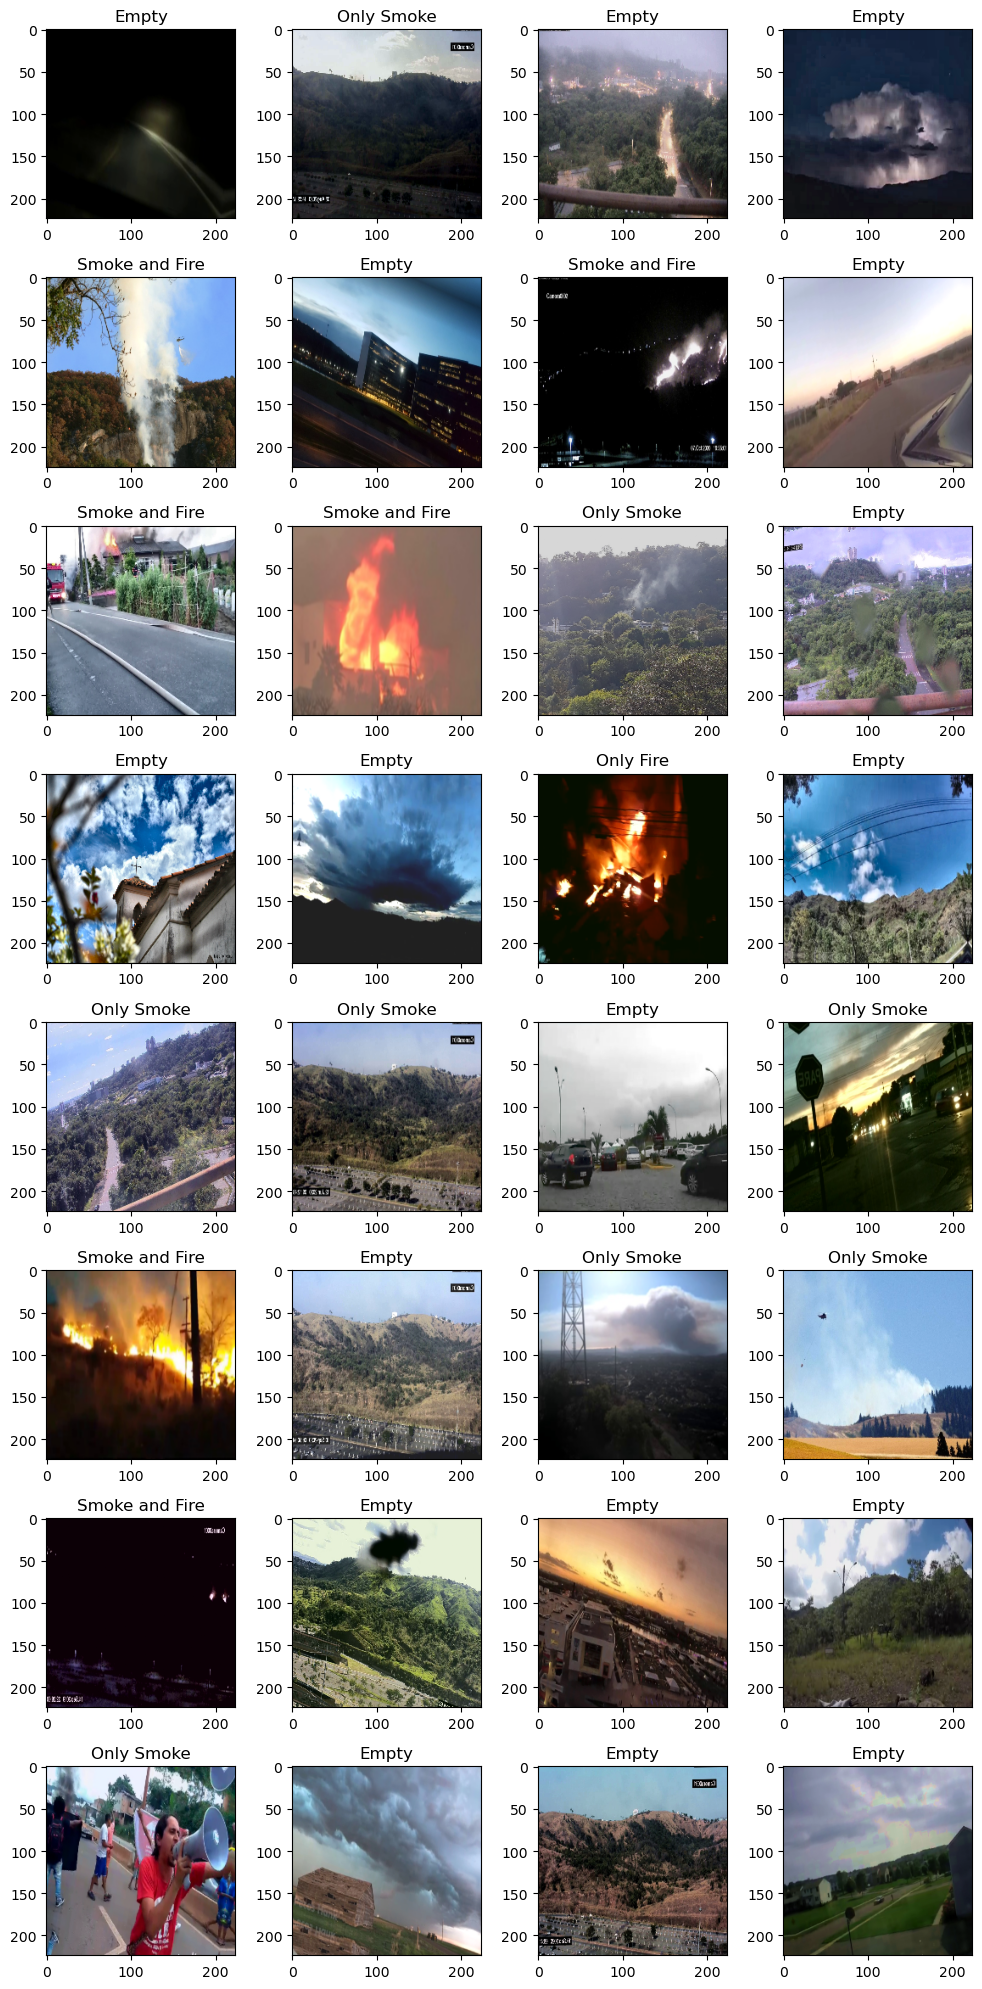

In [32]:
for i, (img, label) in enumerate(view_loader):

    plt.subplots(8,4, figsize=(10, 20))
    
    for idx in range(VIEW_BATCH_SIZE):
        plt.subplot(8, 4, idx+1)
        plt.imshow(img[idx].permute(1, 2, 0))
        title = ""
        if label[idx][0] == 1 and label[idx][1] == 1:
            title += "Smoke and Fire"
        elif label[idx][0] == 1 and label[idx][1] == 0:
            title += "Only Smoke"
        elif label[idx][0] == 0 and label[idx][1] == 1:
            title += "Only Fire"
        else:
            title += "Empty"
        plt.title(title)
        
        if (idx == 31):
            break
    plt.tight_layout()
    plt.show()
    break

# Model: BED Less Layers

In [33]:
class BED_CLASSIFIER(nn.Module):
    def __init__(self, num_classes, in_channels=3):
        super(BED_CLASSIFIER, self).__init__()
        self.in_channels = in_channels
        self.last_channels = 64
        self.num_classes = num_classes
        
        self.model = self.__create_BED__()
        
        self.pool = nn.AdaptiveAvgPool2d((1, 1))
        self.smoke = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )
        self.fire = nn.Sequential(
            nn.Dropout(p=0.2),
            nn.Linear(in_features=self.last_channels, out_features=16),
            nn.ReLU(),
            nn.Linear(in_features=16, out_features=1)
        )

        
    def __create_BED__(self):
        BED_model = nn.Sequential(
            # Conv2d [in_channels, out_channels, kernel_size, stride, padding, bias]

            # CNNBlock 224x224
            nn.Conv2d(self.in_channels, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 112x112
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 24, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(24, affine=False),
            nn.ReLU(),
            nn.Dropout2d(p=0.3),

            # CNNBlock 56x56
            nn.MaxPool2d(kernel_size=2, stride=2),
            # kernel = 1 in github
            nn.Conv2d(24, 16, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(16, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            # kernel = 1 in github
            nn.Conv2d(32, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 28x28
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
            nn.BatchNorm2d(32, affine=False),
            nn.ReLU(),
            
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
            nn.BatchNorm2d(64, affine=False),
            nn.ReLU(),

            # CNNBlock 14x14
#             nn.MaxPool2d(kernel_size=2, stride=2), 
#             nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
#             nn.BatchNorm2d(32, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(64, 32, kernel_size=1, stride=1, padding=0,  bias=False),
#             nn.BatchNorm2d(32, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(64, affine=False),
#             nn.ReLU(),
            
#             # CNNBlock 7x7
#             nn.MaxPool2d(kernel_size=2, stride=2),
#             nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(128, affine=False),
#             nn.ReLU(),
#             nn.Conv2d(128, self.last_channels, kernel_size=3, stride=1, padding=1,  bias=False),
#             nn.BatchNorm2d(self.last_channels, affine=False),
#             nn.ReLU(),
            
        )
        return BED_model
        
          

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_in',
                    nonlinearity='relu'
                )
                if m.bias is not None:
                        nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, 0, 0.01)
                nn.init.constant_(m.bias, 0)


    def forward(self, x):
        x = self.model(x)
        x = self.pool(x)
        x = torch.flatten(x, start_dim=1)
        x = torch.cat((self.smoke(x), self.fire(x)), dim=-1)
        #x = torch.sigmoid(x) # BCE Logits
        return x

# Loss

In [34]:
class BCE_LOSS(nn.Module):
    '''
    dataset output: (image, {smoke: x, fire: x})
    model output: {smoke: x, fire: x}
    '''

    def __init__(self, device, smoke_precision_weight):
        super(BCE_LOSS, self).__init__()
        self.smoke_precision_weight = smoke_precision_weight
        self.device = device
        #self.bce = nn.BCELoss(reduction='mean')
        self.pos_weight = torch.tensor([self.smoke_precision_weight]).to(self.device)
        self.bce_smoke = nn.BCEWithLogitsLoss(reduction='sum', pos_weight=self.pos_weight)
        self.bce_fire = nn.BCEWithLogitsLoss(reduction='sum')
        
        self.eps = 1e-10
        
        self.smoke_loss = 0
        self.fire_loss = 0

    def forward(self, ground_truth, predictions):
        
        # print(f'Ground trunth: {ground_truth}')
        # print(f'Predictions: {predictions}')
        
        # BCELoss: ALWAYS (prediction, target) -> it crashes with NaN if order is wrong
        smoke_loss = self.bce_smoke(predictions[..., 0],
                                    ground_truth[..., 0])
        self.smoke_loss = smoke_loss.item()
        fire_loss = self.bce_fire(predictions[..., 1],
                                  ground_truth[..., 1])
        self.fire_loss = fire_loss.item()
        
        total_loss = smoke_loss + fire_loss
        
        return total_loss

    def get_last_losses(self):     
        return {
            'smoke_loss': self.smoke_loss,
            'fire_loss': self.fire_loss,
        }

# Hyperparameters

In [35]:
''' ============================
    Hyperparameters and More
============================ '''

MODEL = "BED"
#MODEL = "SQUEEZE"

#LEARNING_RATE = 5e-4
LEARNING_RATE = 0.001
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
#DEVICE = "cpu"
BATCH_SIZE = 64 
WEIGHT_DECAY = 1e-4
#WEIGHT_DECAY = 0
EPOCHS = 100 #100
NUM_WORKERS = 4
PIN_MEMORY = True
LOAD_MODEL = False
if MODEL == "BED":
    LOAD_MODEL_FILE = log_path + MODEL + "_classifier_best.pt"
elif MODEL == "SQUEEZE":
    LOAD_MODEL_FILE = log_path + MODEL + "_classifier_best.pt"

LOSS_FN = "BCE"
SMOKE_PRECISION_WEIGHT = 0.7

TRAIN_IMG_DIR = train_imgs
TRAIN_LABEL_DIR = train_labels
VAL_IMG_DIR = val_imgs
VAL_LABEL_DIR = val_labels

LOG_FILE = "log_file.xlsx"

DS_LEN = None


''' ============================
    Metrics
============================ '''
# Loss output
## Train
train_total_loss = []
train_smoke_loss = []
train_fire_loss = []
## Val
val_total_loss = []
val_smoke_loss = []
val_fire_loss = []

# Accuracy, Precision, Recall, F1
## Train
train_smoke_total_accuracy = []
train_smoke_total_precision = []
train_smoke_total_recall = []
train_smoke_total_f1 = []
train_fire_total_accuracy = []
train_fire_total_precision = []
train_fire_total_recall = []
train_fire_total_f1 = []
## Val
val_smoke_total_accuracy = []
val_smoke_total_precision = []
val_smoke_total_recall = []
val_smoke_total_f1 = []
val_fire_total_accuracy = []
val_fire_total_precision = []
val_fire_total_recall = []
val_fire_total_f1 = []

epochs_plot = []

# Metrics

In [36]:
precision_metric = torchmetrics.classification.MultilabelPrecision(num_labels = N_CLASSES, 
                                                                   threshold = 0.5, 
                                                                   average = None).to(DEVICE)
recall_metric = torchmetrics.classification.MultilabelRecall(num_labels = N_CLASSES, 
                                                             threshold = 0.5, 
                                                             average = None).to(DEVICE)
accuracy_metric = torchmetrics.classification.MultilabelAccuracy(num_labels = N_CLASSES, 
                                                                 threshold = 0.5, 
                                                                 average = None).to(DEVICE)
f1_metric = torchmetrics.classification.MultilabelF1Score(num_labels = N_CLASSES, 
                                                          threshold = 0.5, 
                                                          average = None).to(DEVICE)

# Train Loop

In [37]:
'''
Train function
'''
def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def train_fn(loader, model, optimizer, loss_fn, device):
    
    print(f'Learning Rate = {get_lr(optimizer=optimizer)}\n')
    logger.info(f'Learning Rate = {get_lr(optimizer=optimizer)}')

    model.train()
    loop = tqdm(loader, desc='Training', leave=True)
    train_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        train_loss = loss_fn(ground_truth=y, 
                             predictions=out)
      
        # Gradient Descent
        optimizer.zero_grad()
        train_loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=10.0)
        optimizer.step()

        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        train_losses.append(train_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
        
        # print(f'Train loss: {train_loss}')
        # print(f'Train loss: {train_losses}')
        
        model.eval()
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
        model.train()
    
    model.eval()
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()
    model.train()
        
    logger.info("\nTRAIN losses")
    train_mean_loss = sum(train_losses)/len(train_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)


    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{train_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (train_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Validation Loop

In [38]:
'''
Evaluation Function
'''
def eval_fn(loader, model, loss_fn, device):
    
    model.eval()
    loop = tqdm(loader, desc='Validating', leave=True)
    val_losses = []
    smoke_losses = []
    fire_losses = []

    for batch_idx, (x, y) in enumerate(loop):
        x, y = x.to(device), y.to(device)
        out = model(x)
        val_loss = loss_fn(ground_truth=y, 
                           predictions=out)      
        
        # BCE Loss
        last_losses = loss_fn.get_last_losses()
        val_losses.append(val_loss.item())
        smoke_losses.append(last_losses['smoke_loss'])
        fire_losses.append(last_losses['fire_loss'])
    
        # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
        yhat = torch.sigmoid(out.detach())
        precision_metric.update(yhat, y)
        recall = recall_metric.update(yhat, y)
        accuracy = accuracy_metric.update(yhat, y)
        f1 = f1_metric.update(yhat, y)
    
    precision = precision_metric.compute()
    recall = recall_metric.compute()
    accuracy = accuracy_metric.compute()
    f1 = f1_metric.compute()

    logger.info("\nVAL losses")
    val_mean_loss = sum(val_losses)/len(val_losses)
    smoke_mean_loss = sum(smoke_losses)/len(smoke_losses)
    fire_mean_loss = sum(fire_losses)/len(fire_losses)

    print("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    print("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    print(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")
    
    logger.info("Total Loss".ljust(12) + "|" + 
          "Smoke Loss".ljust(12) + "|" + 
          "Fire Loss".ljust(12))
    logger.info("------------".ljust(12) + " " + 
          "------------".ljust(12) + " " + 
          "------------".ljust(12))
    logger.info(f'{val_mean_loss:.3f}'.ljust(12) + "|" +
          f'{smoke_mean_loss:.3f}'.ljust(12) + "|" +
          f'{fire_mean_loss:.3f}'.ljust(12) + "\n")   

    logger.info("VAL Metrics")
    print(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    logger.info(f'SMOKE -> Precision: {precision[0]:.3f} - Recall: {recall[0]:.3f} - Accuracy: {accuracy[0]:.3f} - F1: {f1[0]:.3f}')
    print(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    logger.info(f'FIRE -> Precision: {precision[1]:.3f} - Recall: {recall[1]:.3f} - Accuracy: {accuracy[1]:.3f} - F1: {f1[1]:.3f}')
    
    precision_metric.reset()
    recall_metric.reset()
    accuracy_metric.reset()
    f1_metric.reset()
    
    return (val_mean_loss, 
            smoke_mean_loss, 
            fire_mean_loss,
            accuracy,
            precision,
            recall,
            f1)

# Dataset Setup

In [39]:
train_transform = A.Compose([
        A.HorizontalFlip(p=0.5),
        A.OneOf([
            A.RandomBrightnessContrast(p=0.4),
            A.HueSaturationValue(hue_shift_limit=10, p=0.2),
            A.Blur(blur_limit=(3,3), p=0.3),
            A.CLAHE(clip_limit=2.0, p=0.3),
            A.RGBShift(r_shift_limit=15, g_shift_limit=15, b_shift_limit=15, p=0.5),
        ], p=0.9),
        A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
        A.Resize(IMG_H, IMG_W, p=1),
        #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1),
        ToTensorV2(p=1),
    ]
)

# TRAIN DATASET
print("\nTRAIN DFIRE dataset")
logger.info("\nTRAIN DFIRE dataset")
train_dataset = DFireDataset(img_h = IMG_H,
                             img_w = IMG_W,
                             img_dir = TRAIN_IMG_DIR,
                             label_dir = TRAIN_LABEL_DIR,
                             num_classes=N_CLASSES,
                             ds_len = DS_LEN,
                             transform=train_transform)

print(f'Train dataset len: {len(train_dataset)}')
logger.info(f'Train dataset len: {len(train_dataset)}')


# VALIDATION DATASET
val_transform = A.Compose([
    A.Resize(IMG_H, IMG_W, p=1),
    #A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225), p=1), # Removed to divide by 255. in dataset
    ToTensorV2(p=1),
    ]
)

print("\nTEST DFire dataset")
logger.info("\nTEST DFire dataset")
val_dataset = DFireDataset(img_h = IMG_H,
                           img_w = IMG_W,
                           img_dir = VAL_IMG_DIR,
                           label_dir = VAL_LABEL_DIR,
                           num_classes = N_CLASSES,
                           ds_len = DS_LEN,
                           transform=val_transform)

print(f'Test dataset len: {len(val_dataset)}')
logger.info(f'Test dataset len: {len(val_dataset)}')


# LOADERS
train_loader = DataLoader(dataset=train_dataset,
                          batch_size=BATCH_SIZE,
                          num_workers=NUM_WORKERS,
                          pin_memory=PIN_MEMORY,
                          shuffle=True,
                          drop_last=True)

val_loader = DataLoader(dataset=val_dataset,
                        batch_size=BATCH_SIZE,
                        num_workers=NUM_WORKERS,
                        pin_memory=PIN_MEMORY,
                        shuffle=False,
                        drop_last=True)


TRAIN DFIRE dataset
DFire Removed wrong images: 0
DFire empty images: 7833
DFire only smoke images: 4681
DFire only fire images: 944
DFire smoke and fire images: 3763
Train dataset len: 17221

TEST DFire dataset
DFire Removed wrong images: 0
DFire empty images: 2005
DFire only smoke images: 1186
DFire only fire images: 220
DFire smoke and fire images: 895
Test dataset len: 4306


# Model Setup

In [40]:
''' ======================================
    SETUP: Model, Loss, Dataset, Loader
====================================== '''
if MODEL == "BED":
    print("Using BED Classifier")
    logger.info("Using BED Classifier")
    model = BED_CLASSIFIER(num_classes=N_CLASSES).to(DEVICE)
elif MODEL == "SQUEEZE":
    print("Using Squeeze Classifier")
    logger.info("Using Squeeze Classifier")
    model = SqueezeNet(num_classes=N_CLASSES).to(DEVICE)    
else:
    print("Wrong Model")
    logger.info("Wrong Model")
    raise SystemExit("Wrong Model")

# Check model shape
in_rand_np = np.random.rand(4, 3, IMG_H, IMG_W)
in_rand = torch.tensor(in_rand_np, dtype=torch.float32, device=DEVICE)
out_test = model(in_rand)
print(f'Model shape is {out_test}')
print(f'BED Model Arquitecture\n{model}')
logger.info(f'Model shape is {out_test}')
logger.info(f'BED Model Arquitecture\n{model}')


optimizer = optim.Adam(model.parameters(), 
                       lr=LEARNING_RATE, 
                       weight_decay=WEIGHT_DECAY)
# optimizer = torch.optim.SGD(model.parameters(), 
#                             lr=LEARNING_RATE,
#                             momentum=0.9, 
#                             weight_decay=WEIGHT_DECAY, 
#                             nesterov=True)

scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 
                                                 mode='min',
                                                 factor=0.8, 
                                                 patience=2, 
                                                 threshold=0.001, 
                                                 threshold_mode='abs',
                                                 min_lr=1e-6)

# MODEL PARAMETERS
n_trainable = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f'\nTrainable parameters = {n_trainable}')
logger.info(f'\nTrainable parameters = {n_trainable}')

n_params = parameters_to_vector(model.parameters()).numel()
print(f'Total parameters = {n_params}\n')
logger.info(f'Total parameters = {n_params}\n')

Using BED Classifier
Model shape is tensor([[ 0.1213, -0.5306],
        [ 0.1191, -0.3626],
        [ 0.1145, -0.3514],
        [ 0.1637, -0.3868]], device='cuda:0', grad_fn=<CatBackward0>)
BED Model Arquitecture
BED_CLASSIFIER(
  (model): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (2): ReLU()
    (3): Dropout2d(p=0.3, inplace=False)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 24, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (6): BatchNorm2d(24, eps=1e-05, momentum=0.1, affine=False, track_running_stats=True)
    (7): ReLU()
    (8): Dropout2d(p=0.3, inplace=False)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(24, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (11): BatchNorm2d(16, eps=1e-05, mome

# Main Function

In [41]:
def main(model):

    ''' ============================
        Print Config Values
    ============================ '''
    print(f'Device: {DEVICE}')
    print(f'Learning Rate: {LEARNING_RATE}')
    print(f'Weight Decay: {WEIGHT_DECAY}')
    print(f'Batch Size: {BATCH_SIZE}')
    print(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    print(f'W: {IMG_W}\nH: {IMG_H}')
    
    logger.info(f'Device: {DEVICE}')
    logger.info(f'Learning Rate: {LEARNING_RATE}')
    logger.info(f'Weight Decay: {WEIGHT_DECAY}')
    logger.info(f'Batch Size: {BATCH_SIZE}')
    logger.info(f'IMG DIMS: ({IMG_H}, {IMG_W})')
    logger.info(f'W: {IMG_W}\nH: {IMG_H}')

    
    # LOSS FUNCTION
    if LOSS_FN == "BCE":
        print(f'Loss Function: BCE')
        logger.info(f'Loss Function: BCE')
        print(f'Smoke Precision Weight: {SMOKE_PRECISION_WEIGHT}')
        logger.info(f'Smoke Precision Weight: {SMOKE_PRECISION_WEIGHT}')
        loss_fn = BCE_LOSS(device=DEVICE, smoke_precision_weight=SMOKE_PRECISION_WEIGHT)
    else:
        print("Wrong loss function")
        logger.info("Wrong loss function")
        raise SystemExit("Wrong loss function")

    ''' ==============================================================
                                TRAINING LOOP
    ============================================================== '''
    # Start with infinite validation loss
    best_valid_loss = np.inf
    best_smoke_precision = torch.tensor([0.])
    smoke_f1_min_save = torch.tensor([0.9])

    start = datetime.datetime.now()
    start_time = start.strftime("%H:%M:%S")
    print(f'\n***Start Training: {start_time}\n')
    logger.info(f'\n***Start Training: {start_time}\n')

    start_epoch = 0

    if LOAD_MODEL == False:
        if MODEL == "BED":
            model._initialize_weights()
            print("Initializing Weights")
            logger.info("Initializing Weights")
        elif MODEL == "SQUEEZE":
            print("Weights already initialize in model call")
            logger.info("Weights already initialize in model call")
    else:
        checkpoint = torch.load(LOAD_MODEL_FILE)
        model.load_state_dict(checkpoint['model_state_dict'])
        optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
        start_epoch = checkpoint['epoch']
        print(f"Loading Model. Train from epoch: {start_epoch}")
        logger.info(f"Loading Model. Train from epoch: {start_epoch}")
        
    for epoch in range(start_epoch, EPOCHS):

        print(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        logger.info(f'\n=== EPOCH {epoch}/{EPOCHS-1} ===')
        
        # TRAINING
        train_loss, smoke_loss, fire_loss, tr_acc, tr_pre, tr_rec, tr_f1 = train_fn(loader=train_loader, 
                                                                                    model=model, 
                                                                                    optimizer=optimizer, 
                                                                                    loss_fn=loss_fn,
                                                                                    device=DEVICE)
        # Appending Train Losses
        train_total_loss.append(train_loss)
        train_smoke_loss.append(smoke_loss)
        train_fire_loss.append(fire_loss)
        # Appending Train Metrics
        train_smoke_total_accuracy.append(tr_acc[0].detach().to('cpu'))
        train_smoke_total_precision.append(tr_pre[0].detach().to('cpu'))
        train_smoke_total_recall.append(tr_rec[0].detach().to('cpu'))
        train_smoke_total_f1.append(tr_f1[0].detach().to('cpu'))
        train_fire_total_accuracy.append(tr_acc[1].detach().to('cpu'))
        train_fire_total_precision.append(tr_pre[1].detach().to('cpu'))
        train_fire_total_recall.append(tr_rec[1].detach().to('cpu'))
        train_fire_total_f1.append(tr_f1[1].detach().to('cpu'))
        
        # VALIDATING
        with torch.no_grad():
            val_loss, smoke_loss, fire_loss, v_acc, v_pre, v_rec, v_f1 = eval_fn(loader=val_loader, 
                                                                                 model=model,                         
                                                                                 loss_fn=loss_fn,
                                                                                 device=DEVICE)
            # Appending Validation Losses
            val_total_loss.append(val_loss)
            val_smoke_loss.append(smoke_loss)
            val_fire_loss.append(fire_loss)
            # Appending Validation Metrics
            val_smoke_total_accuracy.append(v_acc[0].detach().to('cpu'))
            val_smoke_total_precision.append(v_pre[0].detach().to('cpu'))
            val_smoke_total_recall.append(v_rec[0].detach().to('cpu'))
            val_smoke_total_f1.append(v_f1[0].detach().to('cpu'))
            val_fire_total_accuracy.append(v_acc[1].detach().to('cpu'))
            val_fire_total_precision.append(v_pre[1].detach().to('cpu'))
            val_fire_total_recall.append(v_rec[1].detach().to('cpu'))
            val_fire_total_f1.append(v_f1[1].detach().to('cpu'))
            
            scheduler.step(val_loss)
            

            epochs_plot.append(epoch)
            plt.plot(epochs_plot, train_total_loss, label="Train Loss")
            plt.plot(epochs_plot, val_total_loss, label="Val Loss")
            plt.title("Train vs Val Loss")
            plt.xlabel("Epochs")
            plt.ylabel("Loss")
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_loss.png")
            plt.close()
            
            # Accuracy
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_accuracy, label="Smoke Train Acc")
            plt.plot(epochs_plot, val_smoke_total_accuracy, label="Smoke Val Acc")
            plt.title("Smoke Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_acc.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_accuracy, label="Fire Train Acc")
            plt.plot(epochs_plot, val_fire_total_accuracy, label="Fire Val Acc")
            plt.title("Fire Train vs Val Acc")
            plt.xlabel("Epochs")
            plt.ylabel("Accuracy")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_acc.png")
            plt.close()
            # Precision
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_precision, label="Smoke Train Prec")
            plt.plot(epochs_plot, val_smoke_total_precision, label="Smoke Val Prec")
            plt.title("Smoke Train vs Val Precision")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_prec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_precision, label="Fire Train Prec")
            plt.plot(epochs_plot, val_fire_total_precision, label="Fire Val Prec")
            plt.title("Fire Train vs Val Prec")
            plt.xlabel("Epochs")
            plt.ylabel("Precision")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_prec.png")
            plt.close()
            # Recall
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_recall, label="Smoke Train Rec")
            plt.plot(epochs_plot, val_smoke_total_recall, label="Smoke Val Rec")
            plt.title("Smoke Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_rec.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_recall, label="Fire Train Rec")
            plt.plot(epochs_plot, val_fire_total_recall, label="Fire Val Rec")
            plt.title("Fire Train vs Val Rec")
            plt.xlabel("Epochs")
            plt.ylabel("Recall")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_rec.png")
            plt.close()
            # F1
            ## Smoke
            plt.plot(epochs_plot, train_smoke_total_f1, label="Smoke Train F1")
            plt.plot(epochs_plot, val_smoke_total_f1, label="Smoke Val F1")
            plt.title("Smoke Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_smoke_f1.png")
            plt.close()
            ## Fire
            plt.plot(epochs_plot, train_fire_total_f1, label="Fire Train F1")
            plt.plot(epochs_plot, val_fire_total_f1, label="Fire Val F1")
            plt.title("Fire Train vs Val F1")
            plt.xlabel("Epochs")
            plt.ylabel("F1")
            plt.ylim([0,1])
            plt.legend()
            plt.grid()
            plt.savefig(log_path + "Temp_bed_fire_f1.png")
            plt.close()

        if ( (epoch+1) % 5 ) == 0:
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + MODEL + '_classifier_5epoch.pt') 
            
        if best_valid_loss > val_loss:
            best_valid_loss = val_loss
            print(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            logger.info(f"\nSaving model with new best validation loss: {best_valid_loss:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_' + MODEL + '_classifier.pt') 

        # Save model if precision increases and F1 > 0.9
        if ( best_smoke_precision < v_pre[0].detach().to('cpu') ) and ( v_f1[0].detach().to('cpu') > smoke_f1_min_save ) :
            best_smoke_precision = v_pre[0].detach().to('cpu')
            print(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            logger.info(f"\nSaving model with new best smoke precision: {best_smoke_precision:.3f}")
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'scheduler_state_dict': scheduler.state_dict()}, log_path + 'best_smoke_' + MODEL + '_classifier.pt') 
        
    logger.info('Saving last model')   
    torch.save(model.state_dict(), log_path + 'last_bed_classifier.pt') 
    
#     save_log(epochs=EPOCHS, 
#              train_total_loss=train_total_loss,
#              train_box_loss=train_box_loss,
#              train_class_loss=train_class_loss,
#              train_confidence_loss=train_confidence_loss,
#              train_noobj_loss=train_noobj_loss,
#              train_mAP=train_mAP,
#              train_class_AP=train_class_AP,
#              train_class_precision=train_class_precision,
#              train_class_recall=train_class_recall,
#              val_total_loss=val_total_loss,
#              val_box_loss=val_box_loss,
#              val_class_loss=val_class_loss,
#              val_confidence_loss=val_confidence_loss,
#              val_noobj_loss=val_noobj_loss,
#              val_mAP=val_mAP,
#              val_class_AP=val_class_AP,
#              val_class_precision=val_class_precision,
#              val_class_recall=val_class_recall,
#              log_file_dst=LOG_FILE)

    end = datetime.datetime.now()
    end_time = end.strftime("%H:%M:%S")
    print(f'\n***Script finished: {end_time}\n')  
    print(f'Time elapsed: {end-start}')
    logger.info(f'\n***Script finished: {end_time}\n')  
    logger.info(f'Time elapsed: {end-start}')
    
    return model

# Main execute

In [42]:
if __name__ == "__main__":
    print("Starting script\n")
    logger.info("Starting script\n")
    model_trained = main(model=model)

Starting script

Device: cuda
Learning Rate: 0.001
Weight Decay: 0.0001
Batch Size: 64
IMG DIMS: (224, 224)
W: 224
H: 224
Loss Function: BCE
Smoke Precision Weight: 0.7

***Start Training: 14:55:39

Initializing Weights

=== EPOCH 0/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:37<00:00,  7.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
68.198      |36.491      |31.707      



Validating: 100%|███████████████████████████████| 67/67 [00:05<00:00, 12.59it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
60.441      |35.650      |24.791      

SMOKE -> Precision: 0.000 - Recall: 0.000 - Accuracy: 0.519 - F1: 0.000
FIRE -> Precision: 0.747 - Recall: 0.492 - Accuracy: 0.825 - F1: 0.593

Saving model with new best validation loss: 60.441

=== EPOCH 1/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:37<00:00,  7.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
61.585      |35.369      |26.215      



Validating: 100%|███████████████████████████████| 67/67 [00:05<00:00, 11.62it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
57.426      |34.605      |22.820      

SMOKE -> Precision: 0.610 - Recall: 0.185 - Accuracy: 0.551 - F1: 0.284
FIRE -> Precision: 0.792 - Recall: 0.592 - Accuracy: 0.854 - F1: 0.677

Saving model with new best validation loss: 57.426

=== EPOCH 2/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:37<00:00,  7.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
58.742      |34.613      |24.129      



Validating: 100%|███████████████████████████████| 67/67 [00:05<00:00, 12.86it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.787      |33.395      |20.393      

SMOKE -> Precision: 0.769 - Recall: 0.145 - Accuracy: 0.568 - F1: 0.244
FIRE -> Precision: 0.774 - Recall: 0.674 - Accuracy: 0.865 - F1: 0.721

Saving model with new best validation loss: 53.787

=== EPOCH 3/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:37<00:00,  7.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
55.932      |34.020      |21.912      



Validating: 100%|███████████████████████████████| 67/67 [00:05<00:00, 11.44it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
52.470      |32.566      |19.903      

SMOKE -> Precision: 0.775 - Recall: 0.383 - Accuracy: 0.650 - F1: 0.513
FIRE -> Precision: 0.747 - Recall: 0.762 - Accuracy: 0.872 - F1: 0.754

Saving model with new best validation loss: 52.470

=== EPOCH 4/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:37<00:00,  7.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
53.617      |33.133      |20.483      



Validating: 100%|███████████████████████████████| 67/67 [00:05<00:00, 12.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.939      |32.056      |17.883      

SMOKE -> Precision: 0.769 - Recall: 0.484 - Accuracy: 0.682 - F1: 0.594
FIRE -> Precision: 0.734 - Recall: 0.823 - Accuracy: 0.877 - F1: 0.776

Saving model with new best validation loss: 49.939

=== EPOCH 5/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:37<00:00,  7.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
51.582      |32.441      |19.142      



Validating: 100%|███████████████████████████████| 67/67 [00:05<00:00, 11.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.533      |30.286      |15.246      

SMOKE -> Precision: 0.760 - Recall: 0.510 - Accuracy: 0.687 - F1: 0.611
FIRE -> Precision: 0.794 - Recall: 0.841 - Accuracy: 0.902 - F1: 0.817

Saving model with new best validation loss: 45.533

=== EPOCH 6/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:37<00:00,  7.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
49.795      |31.821      |17.974      



Validating: 100%|███████████████████████████████| 67/67 [00:05<00:00, 12.76it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.303      |29.761      |15.542      

SMOKE -> Precision: 0.824 - Recall: 0.411 - Accuracy: 0.674 - F1: 0.549
FIRE -> Precision: 0.842 - Recall: 0.795 - Accuracy: 0.908 - F1: 0.818

Saving model with new best validation loss: 45.303

=== EPOCH 7/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:37<00:00,  7.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
48.543      |31.064      |17.479      



Validating: 100%|███████████████████████████████| 67/67 [00:05<00:00, 11.52it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
44.503      |29.242      |15.261      

SMOKE -> Precision: 0.765 - Recall: 0.608 - Accuracy: 0.722 - F1: 0.678
FIRE -> Precision: 0.815 - Recall: 0.799 - Accuracy: 0.901 - F1: 0.807

Saving model with new best validation loss: 44.503

=== EPOCH 8/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:36<00:00,  7.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
47.648      |30.627      |17.021      



Validating: 100%|███████████████████████████████| 67/67 [00:05<00:00, 12.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.522      |27.886      |13.636      

SMOKE -> Precision: 0.785 - Recall: 0.585 - Accuracy: 0.723 - F1: 0.671
FIRE -> Precision: 0.827 - Recall: 0.863 - Accuracy: 0.918 - F1: 0.845

Saving model with new best validation loss: 41.522

=== EPOCH 9/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:38<00:00,  7.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
46.657      |30.103      |16.553      



Validating: 100%|███████████████████████████████| 67/67 [00:05<00:00, 11.57it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.625      |27.033      |13.591      

SMOKE -> Precision: 0.810 - Recall: 0.610 - Accuracy: 0.744 - F1: 0.696
FIRE -> Precision: 0.829 - Recall: 0.850 - Accuracy: 0.916 - F1: 0.839

Saving model with new best validation loss: 40.625

=== EPOCH 10/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:37<00:00,  7.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.736      |29.705      |16.031      



Validating: 100%|███████████████████████████████| 67/67 [00:05<00:00, 12.32it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.328      |26.496      |12.832      

SMOKE -> Precision: 0.835 - Recall: 0.563 - Accuracy: 0.736 - F1: 0.673
FIRE -> Precision: 0.860 - Recall: 0.846 - Accuracy: 0.924 - F1: 0.853

Saving model with new best validation loss: 39.328

=== EPOCH 11/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:38<00:00,  7.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
45.118      |29.220      |15.897      



Validating: 100%|███████████████████████████████| 67/67 [00:05<00:00, 11.53it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.967      |25.608      |12.359      

SMOKE -> Precision: 0.808 - Recall: 0.694 - Accuracy: 0.773 - F1: 0.747
FIRE -> Precision: 0.871 - Recall: 0.844 - Accuracy: 0.927 - F1: 0.857

Saving model with new best validation loss: 37.967

=== EPOCH 12/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:36<00:00,  7.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.882      |28.472      |15.410      



Validating: 100%|███████████████████████████████| 67/67 [00:05<00:00, 11.51it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.357      |25.214      |12.143      

SMOKE -> Precision: 0.809 - Recall: 0.709 - Accuracy: 0.779 - F1: 0.756
FIRE -> Precision: 0.882 - Recall: 0.835 - Accuracy: 0.928 - F1: 0.858

Saving model with new best validation loss: 37.357

=== EPOCH 13/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:39<00:00,  6.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
43.728      |28.584      |15.144      



Validating: 100%|███████████████████████████████| 67/67 [00:06<00:00, 10.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.039      |25.467      |12.573      

SMOKE -> Precision: 0.775 - Recall: 0.779 - Accuracy: 0.785 - F1: 0.777
FIRE -> Precision: 0.822 - Recall: 0.882 - Accuracy: 0.920 - F1: 0.851

=== EPOCH 14/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:38<00:00,  7.04it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
42.467      |27.751      |14.716      



Validating: 100%|███████████████████████████████| 67/67 [00:06<00:00, 10.84it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.951      |24.379      |11.572      

SMOKE -> Precision: 0.853 - Recall: 0.603 - Accuracy: 0.759 - F1: 0.707
FIRE -> Precision: 0.901 - Recall: 0.832 - Accuracy: 0.933 - F1: 0.866

Saving model with new best validation loss: 35.951

=== EPOCH 15/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:39<00:00,  6.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.834      |27.303      |14.530      



Validating: 100%|███████████████████████████████| 67/67 [00:06<00:00, 10.82it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.619      |23.575      |13.043      

SMOKE -> Precision: 0.811 - Recall: 0.730 - Accuracy: 0.788 - F1: 0.768
FIRE -> Precision: 0.810 - Recall: 0.923 - Accuracy: 0.924 - F1: 0.863

=== EPOCH 16/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:37<00:00,  7.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
41.464      |27.038      |14.426      



Validating: 100%|███████████████████████████████| 67/67 [00:06<00:00, 11.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.544      |24.063      |11.481      

SMOKE -> Precision: 0.871 - Recall: 0.575 - Accuracy: 0.754 - F1: 0.693
FIRE -> Precision: 0.913 - Recall: 0.826 - Accuracy: 0.935 - F1: 0.868

Saving model with new best validation loss: 35.544

=== EPOCH 17/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:39<00:00,  6.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.814      |26.595      |14.219      



Validating: 100%|███████████████████████████████| 67/67 [00:06<00:00, 11.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.429      |23.531      |10.897      

SMOKE -> Precision: 0.865 - Recall: 0.585 - Accuracy: 0.756 - F1: 0.698
FIRE -> Precision: 0.931 - Recall: 0.828 - Accuracy: 0.940 - F1: 0.876

Saving model with new best validation loss: 34.429

=== EPOCH 18/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:38<00:00,  7.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.296      |26.378      |13.918      



Validating: 100%|███████████████████████████████| 67/67 [00:06<00:00, 10.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.942      |22.507      |10.434      

SMOKE -> Precision: 0.818 - Recall: 0.763 - Accuracy: 0.804 - F1: 0.790
FIRE -> Precision: 0.883 - Recall: 0.873 - Accuracy: 0.937 - F1: 0.878

Saving model with new best validation loss: 32.942

=== EPOCH 19/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:39<00:00,  6.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
40.331      |26.422      |13.910      



Validating: 100%|███████████████████████████████| 67/67 [00:05<00:00, 11.48it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.466      |22.626      |10.841      

SMOKE -> Precision: 0.809 - Recall: 0.794 - Accuracy: 0.811 - F1: 0.802
FIRE -> Precision: 0.847 - Recall: 0.904 - Accuracy: 0.933 - F1: 0.874

=== EPOCH 20/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:38<00:00,  7.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.487      |25.961      |13.526      



Validating: 100%|███████████████████████████████| 67/67 [00:06<00:00, 11.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.426      |23.559      |10.867      

SMOKE -> Precision: 0.898 - Recall: 0.570 - Accuracy: 0.762 - F1: 0.697
FIRE -> Precision: 0.926 - Recall: 0.834 - Accuracy: 0.940 - F1: 0.878

=== EPOCH 21/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:38<00:00,  6.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
39.537      |25.849      |13.688      



Validating: 100%|███████████████████████████████| 67/67 [00:05<00:00, 12.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.922      |21.553      |10.369      

SMOKE -> Precision: 0.825 - Recall: 0.799 - Accuracy: 0.822 - F1: 0.812
FIRE -> Precision: 0.863 - Recall: 0.917 - Accuracy: 0.941 - F1: 0.889

Saving model with new best validation loss: 31.922

=== EPOCH 22/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:38<00:00,  7.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.673      |25.393      |13.281      



Validating: 100%|███████████████████████████████| 67/67 [00:06<00:00, 11.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.696      |21.249      |10.447      

SMOKE -> Precision: 0.882 - Recall: 0.677 - Accuracy: 0.801 - F1: 0.766
FIRE -> Precision: 0.874 - Recall: 0.902 - Accuracy: 0.941 - F1: 0.888

Saving model with new best validation loss: 31.696

=== EPOCH 23/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:38<00:00,  6.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.042      |25.054      |12.988      



Validating: 100%|███████████████████████████████| 67/67 [00:05<00:00, 12.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.507      |20.419      |10.088      

SMOKE -> Precision: 0.834 - Recall: 0.806 - Accuracy: 0.829 - F1: 0.819
FIRE -> Precision: 0.864 - Recall: 0.915 - Accuracy: 0.941 - F1: 0.889

Saving model with new best validation loss: 30.507

=== EPOCH 24/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:38<00:00,  6.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
38.246      |25.142      |13.105      



Validating: 100%|███████████████████████████████| 67/67 [00:06<00:00, 11.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.543      |21.865      |10.678      

SMOKE -> Precision: 0.828 - Recall: 0.782 - Accuracy: 0.817 - F1: 0.804
FIRE -> Precision: 0.844 - Recall: 0.919 - Accuracy: 0.935 - F1: 0.880

=== EPOCH 25/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:37<00:00,  7.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
37.538      |24.742      |12.796      



Validating: 100%|███████████████████████████████| 67/67 [00:05<00:00, 11.81it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.497      |21.012      |9.484       

SMOKE -> Precision: 0.860 - Recall: 0.756 - Accuracy: 0.823 - F1: 0.805
FIRE -> Precision: 0.902 - Recall: 0.895 - Accuracy: 0.948 - F1: 0.898

Saving model with new best validation loss: 30.497

=== EPOCH 26/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:38<00:00,  6.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.833      |24.402      |12.431      



Validating: 100%|███████████████████████████████| 67/67 [00:06<00:00, 11.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.622      |21.262      |10.359      

SMOKE -> Precision: 0.884 - Recall: 0.664 - Accuracy: 0.796 - F1: 0.758
FIRE -> Precision: 0.936 - Recall: 0.830 - Accuracy: 0.941 - F1: 0.880

=== EPOCH 27/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:37<00:00,  7.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.845      |24.443      |12.401      



Validating: 100%|███████████████████████████████| 67/67 [00:05<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.004      |21.273      |9.731       

SMOKE -> Precision: 0.825 - Recall: 0.821 - Accuracy: 0.830 - F1: 0.823
FIRE -> Precision: 0.873 - Recall: 0.919 - Accuracy: 0.944 - F1: 0.896

=== EPOCH 28/99 ===
Learning Rate = 0.001



Training: 100%|███████████████████████████████| 269/269 [00:38<00:00,  6.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
36.808      |24.240      |12.568      



Validating: 100%|███████████████████████████████| 67/67 [00:05<00:00, 11.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.083      |21.848      |9.235       

SMOKE -> Precision: 0.781 - Recall: 0.914 - Accuracy: 0.835 - F1: 0.842
FIRE -> Precision: 0.894 - Recall: 0.898 - Accuracy: 0.946 - F1: 0.896

=== EPOCH 29/99 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:37<00:00,  7.17it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.477      |23.606      |11.871      



Validating: 100%|███████████████████████████████| 67/67 [00:05<00:00, 11.31it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.164      |19.449      |9.716       

SMOKE -> Precision: 0.849 - Recall: 0.823 - Accuracy: 0.844 - F1: 0.836
FIRE -> Precision: 0.937 - Recall: 0.850 - Accuracy: 0.946 - F1: 0.891

Saving model with new best validation loss: 29.164

=== EPOCH 30/99 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:38<00:00,  6.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.326      |23.572      |11.754      



Validating: 100%|███████████████████████████████| 67/67 [00:05<00:00, 11.39it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.888      |19.853      |9.035       

SMOKE -> Precision: 0.837 - Recall: 0.837 - Accuracy: 0.843 - F1: 0.837
FIRE -> Precision: 0.899 - Recall: 0.919 - Accuracy: 0.952 - F1: 0.909

Saving model with new best validation loss: 28.888

=== EPOCH 31/99 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:37<00:00,  7.26it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
35.145      |23.339      |11.806      



Validating: 100%|███████████████████████████████| 67/67 [00:05<00:00, 11.60it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.669      |18.948      |8.720       

SMOKE -> Precision: 0.873 - Recall: 0.805 - Accuracy: 0.850 - F1: 0.838
FIRE -> Precision: 0.902 - Recall: 0.915 - Accuracy: 0.952 - F1: 0.909

Saving model with new best validation loss: 27.669

=== EPOCH 32/99 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:38<00:00,  6.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.740      |23.015      |11.725      



Validating: 100%|███████████████████████████████| 67/67 [00:05<00:00, 11.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.709      |18.843      |8.865       

SMOKE -> Precision: 0.839 - Recall: 0.873 - Accuracy: 0.858 - F1: 0.856
FIRE -> Precision: 0.924 - Recall: 0.886 - Accuracy: 0.951 - F1: 0.904

=== EPOCH 33/99 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:37<00:00,  7.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.893      |23.190      |11.703      



Validating: 100%|███████████████████████████████| 67/67 [00:05<00:00, 11.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.967      |19.328      |8.640       

SMOKE -> Precision: 0.823 - Recall: 0.867 - Accuracy: 0.847 - F1: 0.845
FIRE -> Precision: 0.916 - Recall: 0.913 - Accuracy: 0.956 - F1: 0.914

=== EPOCH 34/99 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:38<00:00,  7.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
34.225      |22.799      |11.426      



Validating: 100%|███████████████████████████████| 67/67 [00:05<00:00, 11.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.593      |17.900      |8.693       

SMOKE -> Precision: 0.865 - Recall: 0.841 - Accuracy: 0.861 - F1: 0.853
FIRE -> Precision: 0.917 - Recall: 0.900 - Accuracy: 0.953 - F1: 0.909

Saving model with new best validation loss: 26.593

=== EPOCH 35/99 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:36<00:00,  7.28it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.958      |22.528      |11.429      



Validating: 100%|███████████████████████████████| 67/67 [00:05<00:00, 11.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.708      |18.708      |9.001       

SMOKE -> Precision: 0.843 - Recall: 0.864 - Accuracy: 0.857 - F1: 0.854
FIRE -> Precision: 0.943 - Recall: 0.865 - Accuracy: 0.951 - F1: 0.902

=== EPOCH 36/99 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:38<00:00,  6.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.763      |22.506      |11.257      



Validating: 100%|███████████████████████████████| 67/67 [00:05<00:00, 11.37it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.315      |18.048      |8.268       

SMOKE -> Precision: 0.861 - Recall: 0.824 - Accuracy: 0.851 - F1: 0.842
FIRE -> Precision: 0.916 - Recall: 0.918 - Accuracy: 0.957 - F1: 0.917

Saving model with new best validation loss: 26.315

=== EPOCH 37/99 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:32<00:00,  8.25it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.658      |22.412      |11.246      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.959      |18.153      |8.806       

SMOKE -> Precision: 0.842 - Recall: 0.856 - Accuracy: 0.853 - F1: 0.849
FIRE -> Precision: 0.920 - Recall: 0.903 - Accuracy: 0.955 - F1: 0.911

=== EPOCH 38/99 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.83it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
33.268      |22.087      |11.180      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.951      |19.080      |8.871       

SMOKE -> Precision: 0.927 - Recall: 0.694 - Accuracy: 0.826 - F1: 0.793
FIRE -> Precision: 0.925 - Recall: 0.888 - Accuracy: 0.952 - F1: 0.906

=== EPOCH 39/99 ===
Learning Rate = 0.0008



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.773      |21.935      |10.838      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 13.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.611      |17.858      |8.754       

SMOKE -> Precision: 0.894 - Recall: 0.782 - Accuracy: 0.851 - F1: 0.834
FIRE -> Precision: 0.936 - Recall: 0.886 - Accuracy: 0.955 - F1: 0.910

=== EPOCH 40/99 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.376      |21.495      |10.882      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 13.69it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.166      |17.691      |8.475       

SMOKE -> Precision: 0.911 - Recall: 0.773 - Accuracy: 0.854 - F1: 0.836
FIRE -> Precision: 0.945 - Recall: 0.891 - Accuracy: 0.958 - F1: 0.917

Saving model with new best validation loss: 26.166

=== EPOCH 41/99 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.143      |21.312      |10.831      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.517      |16.842      |8.675       

SMOKE -> Precision: 0.891 - Recall: 0.829 - Accuracy: 0.869 - F1: 0.859
FIRE -> Precision: 0.889 - Recall: 0.933 - Accuracy: 0.952 - F1: 0.910

Saving model with new best validation loss: 25.517

=== EPOCH 42/99 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
32.314      |21.524      |10.790      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 13.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.379      |17.216      |8.163       

SMOKE -> Precision: 0.885 - Recall: 0.807 - Accuracy: 0.857 - F1: 0.844
FIRE -> Precision: 0.929 - Recall: 0.902 - Accuracy: 0.957 - F1: 0.915

Saving model with new best validation loss: 25.379

=== EPOCH 43/99 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.514      |20.882      |10.633      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.609      |17.015      |8.593       

SMOKE -> Precision: 0.893 - Recall: 0.807 - Accuracy: 0.861 - F1: 0.848
FIRE -> Precision: 0.897 - Recall: 0.929 - Accuracy: 0.954 - F1: 0.912

=== EPOCH 44/99 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.538      |20.911      |10.627      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.558      |17.375      |8.183       

SMOKE -> Precision: 0.910 - Recall: 0.785 - Accuracy: 0.859 - F1: 0.843
FIRE -> Precision: 0.939 - Recall: 0.887 - Accuracy: 0.956 - F1: 0.912

=== EPOCH 45/99 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.88it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.354      |20.954      |10.400      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.095      |16.760      |8.335       

SMOKE -> Precision: 0.853 - Recall: 0.887 - Accuracy: 0.872 - F1: 0.870
FIRE -> Precision: 0.900 - Recall: 0.918 - Accuracy: 0.952 - F1: 0.909

Saving model with new best validation loss: 25.095

=== EPOCH 46/99 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.85it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.114      |20.593      |10.521      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 13.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.057      |16.545      |8.512       

SMOKE -> Precision: 0.854 - Recall: 0.882 - Accuracy: 0.871 - F1: 0.868
FIRE -> Precision: 0.896 - Recall: 0.931 - Accuracy: 0.954 - F1: 0.913

Saving model with new best validation loss: 25.057

=== EPOCH 47/99 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  8.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.647      |20.417      |10.230      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 13.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.228      |15.947      |8.281       

SMOKE -> Precision: 0.907 - Recall: 0.833 - Accuracy: 0.878 - F1: 0.868
FIRE -> Precision: 0.949 - Recall: 0.886 - Accuracy: 0.958 - F1: 0.917

Saving model with new best validation loss: 24.228

=== EPOCH 48/99 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.831      |20.496      |10.335      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.641      |17.613      |9.028       

SMOKE -> Precision: 0.923 - Recall: 0.735 - Accuracy: 0.843 - F1: 0.818
FIRE -> Precision: 0.947 - Recall: 0.871 - Accuracy: 0.954 - F1: 0.908

=== EPOCH 49/99 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
31.024      |20.622      |10.402      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.911      |16.073      |7.838       

SMOKE -> Precision: 0.908 - Recall: 0.818 - Accuracy: 0.872 - F1: 0.861
FIRE -> Precision: 0.947 - Recall: 0.895 - Accuracy: 0.960 - F1: 0.920

Saving model with new best validation loss: 23.911

=== EPOCH 50/99 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  8.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.583      |20.418      |10.164      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.379      |15.506      |7.873       

SMOKE -> Precision: 0.892 - Recall: 0.861 - Accuracy: 0.883 - F1: 0.876
FIRE -> Precision: 0.931 - Recall: 0.914 - Accuracy: 0.960 - F1: 0.922

Saving model with new best validation loss: 23.379

=== EPOCH 51/99 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.282      |20.364      |9.917       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.05it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.115      |15.448      |8.667       

SMOKE -> Precision: 0.898 - Recall: 0.850 - Accuracy: 0.881 - F1: 0.873
FIRE -> Precision: 0.883 - Recall: 0.938 - Accuracy: 0.952 - F1: 0.910

=== EPOCH 52/99 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.404      |20.181      |10.222      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 13.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.998      |15.832      |8.167       

SMOKE -> Precision: 0.873 - Recall: 0.879 - Accuracy: 0.880 - F1: 0.876
FIRE -> Precision: 0.907 - Recall: 0.918 - Accuracy: 0.955 - F1: 0.913

=== EPOCH 53/99 ===
Learning Rate = 0.00064



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.292      |20.272      |10.020      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.198      |17.024      |8.175       

SMOKE -> Precision: 0.839 - Recall: 0.917 - Accuracy: 0.876 - F1: 0.877
FIRE -> Precision: 0.902 - Recall: 0.932 - Accuracy: 0.956 - F1: 0.917

=== EPOCH 54/99 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
30.077      |20.233      |9.845       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.368      |15.136      |8.232       

SMOKE -> Precision: 0.899 - Recall: 0.852 - Accuracy: 0.883 - F1: 0.875
FIRE -> Precision: 0.893 - Recall: 0.938 - Accuracy: 0.955 - F1: 0.915

Saving model with new best validation loss: 23.368

=== EPOCH 55/99 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.766      |19.614      |10.152      



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.15it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.875      |15.411      |8.464       

SMOKE -> Precision: 0.903 - Recall: 0.838 - Accuracy: 0.879 - F1: 0.869
FIRE -> Precision: 0.884 - Recall: 0.946 - Accuracy: 0.954 - F1: 0.914

=== EPOCH 56/99 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.278      |19.598      |9.680       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.931      |15.490      |8.441       

SMOKE -> Precision: 0.931 - Recall: 0.803 - Accuracy: 0.877 - F1: 0.863
FIRE -> Precision: 0.962 - Recall: 0.864 - Accuracy: 0.956 - F1: 0.910

=== EPOCH 57/99 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.744      |19.125      |9.619       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.169      |15.243      |7.926       

SMOKE -> Precision: 0.869 - Recall: 0.892 - Accuracy: 0.884 - F1: 0.881
FIRE -> Precision: 0.917 - Recall: 0.933 - Accuracy: 0.961 - F1: 0.925

Saving model with new best validation loss: 23.169

=== EPOCH 58/99 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
29.350      |19.528      |9.822       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.564      |14.924      |7.640       

SMOKE -> Precision: 0.914 - Recall: 0.840 - Accuracy: 0.885 - F1: 0.875
FIRE -> Precision: 0.935 - Recall: 0.911 - Accuracy: 0.961 - F1: 0.923

Saving model with new best validation loss: 22.564

=== EPOCH 59/99 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.615      |19.340      |9.275       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.230      |14.429      |7.801       

SMOKE -> Precision: 0.916 - Recall: 0.840 - Accuracy: 0.886 - F1: 0.876
FIRE -> Precision: 0.898 - Recall: 0.932 - Accuracy: 0.955 - F1: 0.915

Saving model with new best validation loss: 22.230

=== EPOCH 60/99 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.476      |19.015      |9.461       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.07it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.510      |14.909      |7.601       

SMOKE -> Precision: 0.901 - Recall: 0.856 - Accuracy: 0.885 - F1: 0.878
FIRE -> Precision: 0.927 - Recall: 0.921 - Accuracy: 0.961 - F1: 0.924

=== EPOCH 61/99 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.608      |19.163      |9.445       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.473      |15.545      |7.928       

SMOKE -> Precision: 0.873 - Recall: 0.887 - Accuracy: 0.883 - F1: 0.880
FIRE -> Precision: 0.917 - Recall: 0.926 - Accuracy: 0.959 - F1: 0.922

=== EPOCH 62/99 ===
Learning Rate = 0.0005120000000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.317      |19.005      |9.312       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 13.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.583      |15.106      |7.477       

SMOKE -> Precision: 0.878 - Recall: 0.906 - Accuracy: 0.894 - F1: 0.892
FIRE -> Precision: 0.933 - Recall: 0.923 - Accuracy: 0.963 - F1: 0.928

=== EPOCH 63/99 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  8.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.892      |18.794      |9.098       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.06it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.674      |15.018      |7.656       

SMOKE -> Precision: 0.869 - Recall: 0.925 - Accuracy: 0.897 - F1: 0.896
FIRE -> Precision: 0.917 - Recall: 0.934 - Accuracy: 0.961 - F1: 0.925

=== EPOCH 64/99 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.90it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
28.208      |18.718      |9.491       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.228      |14.714      |7.514       

SMOKE -> Precision: 0.899 - Recall: 0.865 - Accuracy: 0.889 - F1: 0.882
FIRE -> Precision: 0.941 - Recall: 0.914 - Accuracy: 0.963 - F1: 0.927

Saving model with new best validation loss: 22.228

=== EPOCH 65/99 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.627      |18.433      |9.194       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.417      |14.744      |7.673       

SMOKE -> Precision: 0.923 - Recall: 0.826 - Accuracy: 0.883 - F1: 0.872
FIRE -> Precision: 0.948 - Recall: 0.903 - Accuracy: 0.962 - F1: 0.925

=== EPOCH 66/99 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  8.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.929      |18.530      |9.400       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
23.718      |15.771      |7.947       

SMOKE -> Precision: 0.946 - Recall: 0.775 - Accuracy: 0.870 - F1: 0.852
FIRE -> Precision: 0.950 - Recall: 0.890 - Accuracy: 0.959 - F1: 0.919

=== EPOCH 67/99 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.307      |18.272      |9.035       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.11it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.132      |14.704      |7.428       

SMOKE -> Precision: 0.931 - Recall: 0.815 - Accuracy: 0.882 - F1: 0.869
FIRE -> Precision: 0.937 - Recall: 0.922 - Accuracy: 0.964 - F1: 0.929

Saving model with new best validation loss: 22.132

=== EPOCH 68/99 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.188      |17.971      |9.218       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.08it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.319      |14.843      |7.475       

SMOKE -> Precision: 0.921 - Recall: 0.826 - Accuracy: 0.882 - F1: 0.871
FIRE -> Precision: 0.953 - Recall: 0.905 - Accuracy: 0.964 - F1: 0.928

=== EPOCH 69/99 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.128      |18.128      |9.000       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.232      |13.931      |7.301       

SMOKE -> Precision: 0.905 - Recall: 0.877 - Accuracy: 0.897 - F1: 0.891
FIRE -> Precision: 0.952 - Recall: 0.905 - Accuracy: 0.964 - F1: 0.928

Saving model with new best validation loss: 21.232

=== EPOCH 70/99 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.89it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.277      |18.361      |8.915       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.22it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.466      |13.739      |7.727       

SMOKE -> Precision: 0.913 - Recall: 0.869 - Accuracy: 0.897 - F1: 0.890
FIRE -> Precision: 0.909 - Recall: 0.936 - Accuracy: 0.959 - F1: 0.922

=== EPOCH 71/99 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.146      |18.192      |8.953       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.213      |14.631      |7.582       

SMOKE -> Precision: 0.929 - Recall: 0.814 - Accuracy: 0.881 - F1: 0.868
FIRE -> Precision: 0.941 - Recall: 0.911 - Accuracy: 0.962 - F1: 0.926

=== EPOCH 72/99 ===
Learning Rate = 0.0004096000000000001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
27.115      |18.065      |9.050       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.810      |14.232      |7.578       

SMOKE -> Precision: 0.928 - Recall: 0.834 - Accuracy: 0.889 - F1: 0.878
FIRE -> Precision: 0.919 - Recall: 0.931 - Accuracy: 0.961 - F1: 0.925

=== EPOCH 73/99 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.701      |17.795      |8.906       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.151      |13.814      |7.337       

SMOKE -> Precision: 0.905 - Recall: 0.881 - Accuracy: 0.898 - F1: 0.893
FIRE -> Precision: 0.922 - Recall: 0.929 - Accuracy: 0.961 - F1: 0.925

Saving model with new best validation loss: 21.151

=== EPOCH 74/99 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.693      |17.943      |8.749       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.009      |13.807      |7.202       

SMOKE -> Precision: 0.898 - Recall: 0.892 - Accuracy: 0.899 - F1: 0.895
FIRE -> Precision: 0.929 - Recall: 0.932 - Accuracy: 0.964 - F1: 0.930

Saving model with new best validation loss: 21.009

=== EPOCH 75/99 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.574      |17.593      |8.981       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.280      |13.666      |7.615       

SMOKE -> Precision: 0.922 - Recall: 0.858 - Accuracy: 0.897 - F1: 0.889
FIRE -> Precision: 0.938 - Recall: 0.911 - Accuracy: 0.961 - F1: 0.924

=== EPOCH 76/99 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.858      |17.948      |8.910       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
21.113      |13.523      |7.590       

SMOKE -> Precision: 0.933 - Recall: 0.850 - Accuracy: 0.898 - F1: 0.889
FIRE -> Precision: 0.959 - Recall: 0.886 - Accuracy: 0.961 - F1: 0.921

=== EPOCH 77/99 ===
Learning Rate = 0.0003276800000000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  8.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.215      |17.498      |8.717       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.019      |14.721      |7.298       

SMOKE -> Precision: 0.874 - Recall: 0.917 - Accuracy: 0.896 - F1: 0.895
FIRE -> Precision: 0.922 - Recall: 0.933 - Accuracy: 0.962 - F1: 0.927

=== EPOCH 78/99 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
26.410      |17.670      |8.740       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.259      |13.203      |7.056       

SMOKE -> Precision: 0.914 - Recall: 0.877 - Accuracy: 0.901 - F1: 0.895
FIRE -> Precision: 0.940 - Recall: 0.922 - Accuracy: 0.965 - F1: 0.931

Saving model with new best validation loss: 20.259

=== EPOCH 79/99 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.800      |17.213      |8.587       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.338      |13.103      |7.235       

SMOKE -> Precision: 0.922 - Recall: 0.879 - Accuracy: 0.906 - F1: 0.900
FIRE -> Precision: 0.938 - Recall: 0.917 - Accuracy: 0.963 - F1: 0.928

=== EPOCH 80/99 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.93it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.788      |17.253      |8.535       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.01it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.632      |13.273      |7.359       

SMOKE -> Precision: 0.924 - Recall: 0.869 - Accuracy: 0.903 - F1: 0.896
FIRE -> Precision: 0.935 - Recall: 0.926 - Accuracy: 0.964 - F1: 0.930

=== EPOCH 81/99 ===
Learning Rate = 0.0002621440000000001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.794      |17.347      |8.448       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
22.449      |14.417      |8.031       

SMOKE -> Precision: 0.869 - Recall: 0.928 - Accuracy: 0.898 - F1: 0.898
FIRE -> Precision: 0.896 - Recall: 0.951 - Accuracy: 0.959 - F1: 0.923

=== EPOCH 82/99 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.640      |17.202      |8.438       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.600      |13.496      |7.103       

SMOKE -> Precision: 0.927 - Recall: 0.852 - Accuracy: 0.896 - F1: 0.888
FIRE -> Precision: 0.940 - Recall: 0.923 - Accuracy: 0.965 - F1: 0.932

=== EPOCH 83/99 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.96it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.467      |17.119      |8.348       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.403      |13.043      |7.360       

SMOKE -> Precision: 0.920 - Recall: 0.880 - Accuracy: 0.906 - F1: 0.900
FIRE -> Precision: 0.953 - Recall: 0.901 - Accuracy: 0.963 - F1: 0.926

=== EPOCH 84/99 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.91it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.639      |17.070      |8.569       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.19it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.246      |13.315      |6.931       

SMOKE -> Precision: 0.918 - Recall: 0.868 - Accuracy: 0.899 - F1: 0.892
FIRE -> Precision: 0.937 - Recall: 0.924 - Accuracy: 0.964 - F1: 0.931

Saving model with new best validation loss: 20.246

=== EPOCH 85/99 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.00it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.105      |16.726      |8.379       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.922      |12.871      |7.051       

SMOKE -> Precision: 0.921 - Recall: 0.888 - Accuracy: 0.909 - F1: 0.904
FIRE -> Precision: 0.936 - Recall: 0.925 - Accuracy: 0.964 - F1: 0.931

Saving model with new best validation loss: 19.922

Saving model with new best smoke precision: 0.921

=== EPOCH 86/99 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.289      |17.010      |8.279       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.09it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.838      |12.839      |6.999       

SMOKE -> Precision: 0.913 - Recall: 0.896 - Accuracy: 0.909 - F1: 0.904
FIRE -> Precision: 0.934 - Recall: 0.931 - Accuracy: 0.965 - F1: 0.932

Saving model with new best validation loss: 19.838

=== EPOCH 87/99 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.844      |17.247      |8.597       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.16it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.955      |13.004      |6.952       

SMOKE -> Precision: 0.921 - Recall: 0.876 - Accuracy: 0.904 - F1: 0.898
FIRE -> Precision: 0.927 - Recall: 0.933 - Accuracy: 0.964 - F1: 0.930

=== EPOCH 88/99 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  8.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.275      |16.705      |8.570       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.23it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.189      |13.021      |7.168       

SMOKE -> Precision: 0.912 - Recall: 0.890 - Accuracy: 0.906 - F1: 0.901
FIRE -> Precision: 0.936 - Recall: 0.925 - Accuracy: 0.964 - F1: 0.931

=== EPOCH 89/99 ===
Learning Rate = 0.00020971520000000012



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  8.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
25.109      |16.800      |8.309       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
20.213      |13.175      |7.038       

SMOKE -> Precision: 0.920 - Recall: 0.874 - Accuracy: 0.903 - F1: 0.897
FIRE -> Precision: 0.935 - Recall: 0.932 - Accuracy: 0.965 - F1: 0.933

=== EPOCH 90/99 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  8.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.791      |16.769      |8.022       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.12it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.753      |12.662      |7.092       

SMOKE -> Precision: 0.928 - Recall: 0.880 - Accuracy: 0.910 - F1: 0.903
FIRE -> Precision: 0.938 - Recall: 0.923 - Accuracy: 0.964 - F1: 0.930

Saving model with new best validation loss: 19.753

Saving model with new best smoke precision: 0.928

=== EPOCH 91/99 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.95it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.910      |16.780      |8.130       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.21it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.813      |12.710      |7.103       

SMOKE -> Precision: 0.907 - Recall: 0.907 - Accuracy: 0.911 - F1: 0.907
FIRE -> Precision: 0.927 - Recall: 0.936 - Accuracy: 0.964 - F1: 0.931

=== EPOCH 92/99 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.92it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.511      |16.370      |8.141       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.27it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.556      |12.668      |6.888       

SMOKE -> Precision: 0.910 - Recall: 0.895 - Accuracy: 0.907 - F1: 0.902
FIRE -> Precision: 0.934 - Recall: 0.927 - Accuracy: 0.964 - F1: 0.930

Saving model with new best validation loss: 19.556

=== EPOCH 93/99 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  8.97it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.580      |16.579      |8.001       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.718      |12.666      |7.052       

SMOKE -> Precision: 0.914 - Recall: 0.892 - Accuracy: 0.908 - F1: 0.903
FIRE -> Precision: 0.935 - Recall: 0.933 - Accuracy: 0.966 - F1: 0.934

=== EPOCH 94/99 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  8.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.522      |16.610      |7.912       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.10it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.725      |12.821      |6.904       

SMOKE -> Precision: 0.926 - Recall: 0.872 - Accuracy: 0.905 - F1: 0.898
FIRE -> Precision: 0.950 - Recall: 0.914 - Accuracy: 0.965 - F1: 0.932

=== EPOCH 95/99 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.03it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.843      |16.492      |8.351       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.30it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.243      |12.469      |6.774       

SMOKE -> Precision: 0.929 - Recall: 0.882 - Accuracy: 0.910 - F1: 0.905
FIRE -> Precision: 0.936 - Recall: 0.928 - Accuracy: 0.965 - F1: 0.932

Saving model with new best validation loss: 19.243

Saving model with new best smoke precision: 0.929

=== EPOCH 96/99 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  8.99it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.764      |16.525      |8.238       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.20it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.999      |12.928      |7.071       

SMOKE -> Precision: 0.927 - Recall: 0.871 - Accuracy: 0.905 - F1: 0.898
FIRE -> Precision: 0.930 - Recall: 0.933 - Accuracy: 0.965 - F1: 0.932

=== EPOCH 97/99 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  8.98it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.719      |16.473      |8.246       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.13it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.697      |12.744      |6.953       

SMOKE -> Precision: 0.928 - Recall: 0.866 - Accuracy: 0.903 - F1: 0.896
FIRE -> Precision: 0.944 - Recall: 0.923 - Accuracy: 0.966 - F1: 0.933

=== EPOCH 98/99 ===
Learning Rate = 0.0001677721600000001



Training: 100%|███████████████████████████████| 269/269 [00:30<00:00,  8.94it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.783      |16.714      |8.068       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.14it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.396      |12.618      |6.778       

SMOKE -> Precision: 0.911 - Recall: 0.908 - Accuracy: 0.913 - F1: 0.909
FIRE -> Precision: 0.940 - Recall: 0.925 - Accuracy: 0.965 - F1: 0.932

=== EPOCH 99/99 ===
Learning Rate = 0.00013421772800000008



Training: 100%|███████████████████████████████| 269/269 [00:29<00:00,  9.02it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
24.300      |16.211      |8.089       



Validating: 100%|███████████████████████████████| 67/67 [00:04<00:00, 14.18it/s]


Total Loss  |Smoke Loss  |Fire Loss   
------------ ------------ ------------
19.001      |12.233      |6.769       

SMOKE -> Precision: 0.926 - Recall: 0.885 - Accuracy: 0.911 - F1: 0.905
FIRE -> Precision: 0.930 - Recall: 0.926 - Accuracy: 0.963 - F1: 0.928

Saving model with new best validation loss: 19.001

***Script finished: 16:00:06

Time elapsed: 1:04:27.171547


# Confusion Matrix

In [43]:
# smoke_conf_mtx_metric = torchmetrics.classification.BinaryConfusionMatrix(threshold = 0.5).to(DEVICE)
# fire_conf_mtx_metric = torchmetrics.classification.BinaryConfusionMatrix(threshold = 0.5).to(DEVICE)

In [44]:
# def get_conf_mtx(loader, model, device):

#     model.eval()
#     loop = tqdm(loader, desc='Validating', leave=True)

#     for batch_idx, (x, y) in enumerate(loop):
#         x, y = x.to(device), y.to(device)
#         out = model(x) 
    
#         # Metrics -> Maybe change to metric.update(), sin hacer precision = ...
#         #yhat = torch.sigmoid(out.detach())
#         yhat = out.detach() # La metrica entiende que son logits y aplica sigmoid
#         smoke_conf_mtx_metric.update(yhat[..., 0], y[..., 0])
#         fire_conf_mtx_metric.update(yhat[..., 1], y[..., 1])
    
#     smoke_conf_mtx = smoke_conf_mtx_metric.compute()
#     fire_conf_mtx = fire_conf_mtx_metric.compute()
#     # smoke_conf_mtx_metric.reset()
#     # fire_conf_mtx_metric.reset()
    
#     return smoke_conf_mtx, fire_conf_mtx

In [46]:
# smoke_conf_mtx, fire_conf_mtx = get_conf_mtx(loader=val_loader,
#                                              model=model_trained,
#                                              device=DEVICE)
# print(smoke_conf_mtx)
# print(fire_conf_mtx)

### Smoke confusion matrix

In [ ]:
# fig, ax = smoke_conf_mtx_metric.plot()
# fig.suptitle("Smoke Confusion Matrix")
# fig.set_size_inches(3,3)
# fig.savefig("xs_ultra_tiny_precision_weighted_save/smoke_conf_mtx.png")

### Fire confusion matrix

In [ ]:
# fig, ax = fire_conf_mtx_metric.plot()
# fig.suptitle("Fire Confusion Matrix")
# fig.set_size_inches(3,3)
# fig.savefig("xs_ultra_tiny_precision_weighted_save/fire_conf_mtx.png")

# Confusion Matrix 4 classes

In [ ]:
# def get_conf_mtx_4_classes(loader, model, device):

#     empty_row = np.zeros((4))
#     smoke_row = np.zeros((4))
#     fire_row = np.zeros((4))
#     smoke_fire_row = np.zeros((4))  

#     empty = torch.tensor([0, 0], dtype= torch.float32).to(device)
#     smoke = torch.tensor([1, 0], dtype= torch.float32).to(device)
#     fire = torch.tensor([0, 1], dtype= torch.float32).to(device)
#     smoke_fire = torch.tensor([1, 1], dtype= torch.float32).to(device)
    
#     model.eval()
#     loop = tqdm(loader, desc='Validating', leave=True)

#     for batch_idx, (x, y) in enumerate(loop):
#         x, y = x.to(device), y.to(device)
#         out = model(x) 
#         yhat = torch.round(torch.sigmoid(out.detach()))
        
#         for i in range(x.shape[0]):
#             # Empty class
#             if torch.equal(y[i], empty):
#                 if torch.equal(yhat[i], empty):
#                     empty_row[0] += 1
#                 elif torch.equal(yhat[i], smoke):
#                     empty_row[1] += 1
#                 elif torch.equal(yhat[i], fire):
#                     empty_row[2] += 1
#                 elif torch.equal(yhat[i], smoke_fire):
#                     empty_row[3] += 1
#                 else:
#                     print("Error")
#             # Smoke class
#             if torch.equal(y[i], smoke):
#                 if torch.equal(yhat[i], empty):
#                     smoke_row[0] += 1
#                 elif torch.equal(yhat[i], smoke):
#                     smoke_row[1] += 1
#                 elif torch.equal(yhat[i], fire):
#                     smoke_row[2] += 1
#                 elif torch.equal(yhat[i], smoke_fire):
#                     smoke_row[3] += 1
#                 else:
#                     print("Error")
#             # Fire class
#             if torch.equal(y[i], fire):
#                 if torch.equal(yhat[i], empty):
#                     fire_row[0] += 1
#                 elif torch.equal(yhat[i], smoke):
#                     fire_row[1] += 1
#                 elif torch.equal(yhat[i], fire):
#                     fire_row[2] += 1
#                 elif torch.equal(yhat[i], smoke_fire):
#                     fire_row[3] += 1
#                 else:
#                     print("Error")
#             # Smoke and Fire class
#             if torch.equal(y[i], smoke_fire):
#                 if torch.equal(yhat[i], empty):
#                     smoke_fire_row[0] += 1
#                 elif torch.equal(yhat[i], smoke):
#                     smoke_fire_row[1] += 1
#                 elif torch.equal(yhat[i], fire):
#                     smoke_fire_row[2] += 1
#                 elif torch.equal(yhat[i], smoke_fire):
#                     smoke_fire_row[3] += 1
#                 else:
#                     print("Error")
    
#     return np.stack((empty_row, smoke_row, fire_row, smoke_fire_row))

In [ ]:
# conf_mtx_4 = get_conf_mtx_4_classes(loader=val_loader, 
#                                     model=model_trained,
#                                     device=DEVICE)

In [ ]:
# print(conf_mtx_4)

In [ ]:
# conf_mtx_4[0, ...] = conf_mtx_4[0, ...] / np.sum(conf_mtx_4[0, ...])
# conf_mtx_4[1, ...] = conf_mtx_4[1, ...] / np.sum(conf_mtx_4[1, ...])
# conf_mtx_4[2, ...] = conf_mtx_4[2, ...] / np.sum(conf_mtx_4[2, ...])
# conf_mtx_4[3, ...] = conf_mtx_4[3, ...] / np.sum(conf_mtx_4[3, ...])
# fig, ax = plt.subplots()
# fig.suptitle('Conf MTX Normalized')
# ax.matshow(conf_mtx_4, cmap='RdPu')
# for (i, j), z in np.ndenumerate(conf_mtx_4):
#     ax.text(j, i, '{:0.2f}'.format(z), ha='center', va='center')
# #ax.matshow(conf_mtx_4, cmap='Blues')
# #ax.set_xticklabels(['empty', 'smoke', 'fire', 'smoke & fire'])
# ax.set_xlabel('Predicted')
# ax.set_ylabel('True')
# ax.set_yticks(range(4), ['empty', 'smoke', 'fire', 'smoke & fire'])
# ax.set_xticks(range(4), ['empty', 'smoke', 'fire', 'smoke & fire'])
# plt.show()

# Plot Results

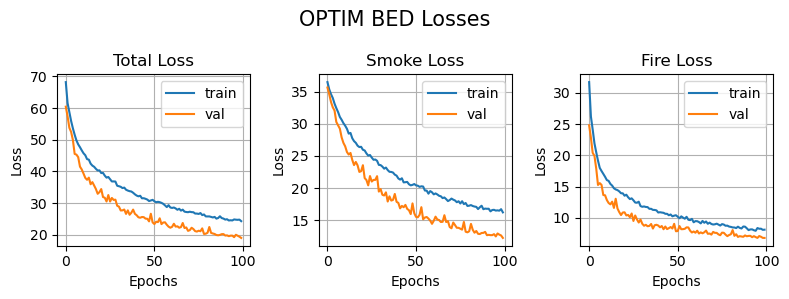

In [47]:
#plt.figure(figsize=(8,8))
fig, axs = plt.subplots(1,3, figsize=(8, 3))
fig.suptitle('OPTIM BED Losses', fontsize=15)

plt.subplot(1,3,1)
plt.plot(train_total_loss, label="train")
plt.plot(val_total_loss, label="val")
plt.title("Total Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,2)
plt.plot(train_smoke_loss, label="train")
plt.plot(val_smoke_loss, label="val")
plt.title("Smoke Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.subplot(1,3,3)
plt.plot(train_fire_loss, label="train")
plt.plot(val_fire_loss, label="val")
plt.title("Fire Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.grid()

plt.tight_layout()
plt.savefig(log_path + "bed_losses.png")
plt.show()